In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import os
import datetime
import pandas as pd
import shutil

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
import tensorflow.keras.backend as K


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
mol='_attn_dice_'

# Parameters
PATCH_SIZE = 256
NUM_CHANNELS = 3
NUM_CLASSES = 1
BATCH_SIZE = 16

dt_tm=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

sys_info=dt_tm
file_sig = "attn_dice"

dt_tm = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
file_Sig = mol + dt_tm

# Update paths for Kaggle
patches_dir = "/content/gdrive/MyDrive/ITMO/01_BRIGHT_FIELD/857x21"

out_path= '/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_Output_Files/'+file_Sig+'/'
tensor_path='/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_TensorBoard/'+file_Sig+'/'
tensor_log_path='/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_TensorBoard/'+file_Sig+'/log/'
keras_path='/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_Keras/'+file_Sig+"/"

keras_file=keras_path+file_Sig+'.keras'

os.makedirs(os.path.join(out_path, 'images'), exist_ok=True)
os.makedirs(keras_path, exist_ok=True)
os.makedirs(tensor_log_path, exist_ok=True)

print(f"File Signature:{file_Sig} indicates file/folder name")

File Signature:_attn_dice_2025-08-20 15:11:52 indicates file/folder name


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Add, Conv2D

try:
    from tensorflow_addons.layers import InstanceNormalization
    instance_norm_available = True
except ImportError:
    InstanceNormalization = None
    instance_norm_available = False

class InstanceActivation(tf.keras.layers.Layer):
    def __init__(self, name_prefix='ia', debug=False, **kwargs):
        super().__init__(name=name_prefix, **kwargs)
        self.name_prefix = name_prefix
        self.debug = debug

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.conv = Conv2D(self.filters, (1, 1), activation='relu', padding='same', name=f'{self.name_prefix}_conv')
        self.bn = BatchNormalization(name=f'{self.name_prefix}_bn')

    def call(self, x):
        out = self.conv(x)
        out = self.bn(out)
        if self.debug:
            tf.print(f"[DEBUG] {self.name_prefix}: input shape =", tf.shape(x), ", out shape =", tf.shape(out))
        return Add(name=f'{self.name_prefix}_add')([x, out])

def attention_gate(x, g, inter_channels, name_prefix):
    theta_x = layers.Conv2D(inter_channels, (1, 1), name=f'{name_prefix}_theta_x')(x)
    phi_g = layers.Conv2D(inter_channels, (1, 1), name=f'{name_prefix}_phi_g')(g)
    add = layers.Add(name=f'{name_prefix}_add')([theta_x, phi_g])
    act = layers.Activation('relu', name=f'{name_prefix}_relu')(add)
    psi = layers.Conv2D(1, (1, 1), name=f'{name_prefix}_psi')(act)
    psi = layers.Activation('sigmoid', name=f'{name_prefix}_sigmoid')(psi)
    return layers.Multiply(name=f'{name_prefix}_multiply')([x, psi])

def upsample(filters, size):
    return tf.keras.Sequential([
        layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
        layers.ReLU(),
        BatchNormalization()
    ])

def decoder_conv_block(x, filters, name_prefix):
    x = Conv2D(filters, (3, 3), padding='same', name=f'{name_prefix}_conv1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = layers.ReLU(name=f'{name_prefix}_relu1')(x)
    x = Conv2D(filters, (3, 3), padding='same', name=f'{name_prefix}_conv2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2')(x)
    x = layers.ReLU(name=f'{name_prefix}_relu2')(x)
    return x

def norm_layer(use_instance_norm):
    if use_instance_norm and instance_norm_available:
        return InstanceNormalization()
    return BatchNormalization()

def Unet_Resnet_Vgg16(
    backbone='resnet50',
    input_shape=(256, 256, 3),
    num_classes=1,
    use_attention=False,
    use_instance_norm=False,
    use_ia=False,
    use_mixed_precision=False
):
    if use_mixed_precision:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy('mixed_float16')

    if backbone == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        layer_names = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
        backbone_filters = [64, 256, 512, 1024, 2048]
    elif backbone == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        layer_names = ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']
        backbone_filters = [64, 128, 256, 512, 512]
    else:
        raise ValueError("Supported backbones: 'resnet50', 'vgg16'")

    for layer in base_model.layers:
        layer.trainable = False

    inputs = base_model.input
    e1 = base_model.get_layer(layer_names[0]).output
    e2 = base_model.get_layer(layer_names[1]).output
    e3 = base_model.get_layer(layer_names[2]).output
    e4 = base_model.get_layer(layer_names[3]).output
    e5 = base_model.get_layer(layer_names[4]).output

    # Decoder Block 1
    d1 = upsample(backbone_filters[-2], 3)(e5)
    if use_attention:
        e4 = attention_gate(e4, d1, backbone_filters[-2] // 2, name_prefix='attn1')
    d1 = layers.Concatenate()([d1, e4])
    d1 = decoder_conv_block(d1, backbone_filters[-2], name_prefix='dec1')
    if use_ia:
        d1 = InstanceActivation(name_prefix='ia1')(d1)
    d1 = Dropout(0.2)(d1)

    # Decoder Block 2
    d2 = upsample(backbone_filters[-3], 3)(d1)
    if use_attention:
        e3 = attention_gate(e3, d2, backbone_filters[-3] // 2, name_prefix='attn2')
    d2 = layers.Concatenate()([d2, e3])
    d2 = decoder_conv_block(d2, backbone_filters[-3], name_prefix='dec2')
    if use_ia:
        d2 = InstanceActivation(name_prefix='ia2')(d2)
    d2 = Dropout(0.3)(d2)

    # Decoder Block 3
    d3 = upsample(backbone_filters[-4], 3)(d2)
    if use_attention:
        e2 = attention_gate(e2, d3, backbone_filters[-4] // 2, name_prefix='attn3')
    d3 = layers.Concatenate()([d3, e2])
    d3 = decoder_conv_block(d3, backbone_filters[-4], name_prefix='dec3')
    if use_ia:
        d3 = InstanceActivation(name_prefix='ia3')(d3)
    d3 = Dropout(0.35)(d3)

    # Decoder Block 4
    d4 = upsample(backbone_filters[-5], 3)(d3)
    if use_attention:
        e1 = attention_gate(e1, d4, backbone_filters[-5] // 2, name_prefix='attn4')
    d4 = layers.Concatenate()([d4, e1])
    d4 = decoder_conv_block(d4, backbone_filters[-5], name_prefix='dec4')
    if use_ia:
        d4 = InstanceActivation(name_prefix='ia4')(d4)
    d4 = Dropout(0.4)(d4)

    d5 = upsample(backbone_filters[0], 3)(d4)
    d5 = decoder_conv_block(d5, backbone_filters[0], name_prefix='dec5')

    outputs = layers.Conv2D(
        num_classes,
        kernel_size=1,
        activation='sigmoid',
        kernel_regularizer=regularizers.L2(1e-4),
        dtype='float32' if use_mixed_precision else None
    )(d5)

    model = Model(inputs, outputs)
    return model


#  Example usage:
model = Unet_Resnet_Vgg16(
    backbone='vgg16',
    use_attention=True,
    use_ia=False,
    use_instance_norm=False,
    use_mixed_precision=True
)



# Example usage:
model = Unet_Resnet_Vgg16(backbone='vgg16', use_attention=True, use_ia=True)
print("Total params:", model.count_params())
print("Trainable params:", sum(tf.keras.backend.count_params(p) for p in model.trainable_weights))

# Debug print for attention and IA layers
print("\nAttention layers params:")
for layer in model.layers:
    if 'attn' in layer.name:
        print(f"{layer.name}: {layer.count_params()} params")

print("\nInstance Activation layers params:")
for layer in model.layers:
    if 'ia' in layer.name:
        print(f"{layer.name}: {layer.count_params()} params")

I0000 00:00:1754151571.649084      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754151571.649802      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total params: 28851173
Trainable params: 14128421

Attention layers params:
attn1_theta_x: 131328 params
attn1_phi_g: 131328 params
attn1_add: 0 params
attn1_relu: 0 params
attn1_psi: 257 params
attn1_sigmoid: 0 params
attn1_multiply: 0 params
attn2_theta_x: 32896 params
attn2_phi_g: 32896 params
attn2_add: 0 params
attn2_relu: 0 params
attn2_psi: 129 params
attn2_sigmoid: 0 params
attn2_multiply: 0 params
attn3_theta_x: 8256 params
attn3_phi_g: 8256 params
attn3_add: 0 params
attn3_relu: 0 params
attn3_psi: 65 params
attn3_sigmoid: 0 params
attn3_multiply: 0 params
attn4_theta_x: 2080 params
attn4_phi_g: 2080 params
attn4_add: 0 params
attn4_relu: 0 params
attn4_psi: 33 params
attn4_sigmoid: 0 params
attn4_multiply: 0 params

Instance Activation layers params:
sequential_5: 2361856 params
ia1: 264704 params
sequential_6: 1180928 params
ia2: 66816 params
sequential_7: 295552 params
ia3: 17024 params
sequential_8: 74048 params
ia4: 4416

In [ ]:
class PatchDataGenerator(Sequence):
    def __init__(self, patches_dir, indices=None, batch_size=BATCH_SIZE, img_size=PATCH_SIZE, **kwargs):  # ✅ Include **kwargs here
        super().__init__(**kwargs)  # ✅ Now this works
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_files = sorted([os.path.join(patches_dir, 'images', fname) for fname in os.listdir(os.path.join(patches_dir, 'images'))])
        self.mask_files = sorted([os.path.join(patches_dir, 'masks', fname) for fname in os.listdir(os.path.join(patches_dir, 'masks'))])
        if indices is not None:
            self.image_files = [self.image_files[i] for i in indices]
            self.mask_files = [self.mask_files[i] for i in indices]
        self.indices = np.arange(len(self.image_files))

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = np.array([np.load(self.image_files[i]) for i in batch_indices])
        Y_batch = np.array([np.load(self.mask_files[i]) for i in batch_indices])
        return X_batch, Y_batch

In [ ]:

# Metrics and Loss

def jaccard_score(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_pred = K.round(y_pred)  # Convert probabilities to binary predictions (0 or 1)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())  # Add epsilon to avoid division by zero


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def dice_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

def dice_bce_loss(y_true, y_pred, bce_weight=0.5, smooth=1e-6):
    # Dice Loss
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    # Weighted BCE (no manual weight needed if using class weights)
    bce_loss = K.binary_crossentropy(y_true, y_pred)

    # Combined Loss
    return bce_weight * bce_loss + (1 - bce_weight) * dice_loss

In [ ]:
model = Unet_Resnet_Vgg16(
    backbone='vgg16',
    use_attention=True,
    use_instance_norm=False,
    use_mixed_precision=True,
    use_ia=False
)



from tensorflow.keras.optimizers.schedules import ExponentialDecay
lr_schedule1 = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)


model.compile(
    optimizer=Adam(learning_rate=lr_schedule1),
    loss=dice_bce_loss, #binary_crossentropy,
    metrics=[
        tf.keras.metrics.TruePositives(name="TP"),
        tf.keras.metrics.FalsePositives(name="FP"),
        tf.keras.metrics.TrueNegatives(name="TN"),
        tf.keras.metrics.FalseNegatives(name="FN"),
        'accuracy',
        recall_m,
        precision_m,
        f1_m,
        jaccard_score
    ]
)
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 256, 256,  │          0 │ input_layer_12[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ cast_3[0][0]      │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0

 Total params: 28,498,213 (108.71 MB)

 Trainable params: 13,777,381 (52.56 MB)

 Non-trainable params: 14,720,832 (56.16 MB)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
import os

# Known prefixes
PREFIXES = ["C_", "S_", "H_", "g_", ""]  # "" handles plain img_/mask_

# Helper: extract prefix, key, and type (image/mask)
def extract_key_and_prefix(fname, img_or_mask):
    for prefix in PREFIXES:
        img_prefix = f"{prefix}img_" if prefix else "img_"
        mask_prefix = f"{prefix}mask_" if prefix else "mask_"

        if img_or_mask == "img" and fname.startswith(img_prefix):
            return fname.replace(img_prefix, ""), prefix if prefix else "plain"
        elif img_or_mask == "mask" and fname.startswith(mask_prefix):
            return fname.replace(mask_prefix, ""), prefix if prefix else "plain"
    return None, None  # Unrecognized

# Directories
image_dir = os.path.join(patches_dir, 'images')
mask_dir = os.path.join(patches_dir, 'masks')

# Build image dictionary
image_dict = {}
for fname in os.listdir(image_dir):
    if not fname.endswith(".npy"):
        continue
    key, prefix = extract_key_and_prefix(fname, "img")
    if key:
        image_dict[(key, prefix)] = os.path.join(image_dir, fname)

# Build mask dictionary
mask_dict = {}
for fname in os.listdir(mask_dir):
    if not fname.endswith(".npy"):
        continue
    key, prefix = extract_key_and_prefix(fname, "mask")
    if key:
        mask_dict[(key, prefix)] = os.path.join(mask_dir, fname)

# Get matching image-mask pairs
matching_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))

# Final aligned file lists
image_files = [image_dict[k] for k in matching_keys]
mask_files = [mask_dict[k] for k in matching_keys]

In [ ]:
# Data Split
train_indices, val_indices = train_test_split(np.arange(len(image_files)), test_size=0.2, random_state=42)

train_gen = PatchDataGenerator(patches_dir, indices=train_indices, batch_size=BATCH_SIZE)
val_gen = PatchDataGenerator(patches_dir, indices=val_indices, batch_size=BATCH_SIZE)

In [ ]:
# Callbacks
log_dir = os.path.join(tensor_log_path, "fit_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch' )
#checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(keras_path, save_best_only=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=keras_path+file_Sig+"_1st_{epoch:02d}.keras",  # dynamic naming
    save_freq='epoch',
    save_weights_only=False,  # Save the full model (not just weights)
    save_best_only=False,     # Save all epochs (not just the best one)
    verbose=1
)

csv_logger = tf.keras.callbacks.CSVLogger("training_log.csv", append=True)

In [ ]:
# Train with more epochs
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=45,
    callbacks=[csv_logger, tensorboard_callback, checkpoint_callback, early_stopping],
    verbose=1,
    #workers=45,
    #use_multiprocessing=True,
    #max_queue_size=10
)

Epoch 1/45


I0000 00:00:1754151649.210978      99 service.cc:148] XLA service 0x79b99c010eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754151649.211978      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754151649.211997      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754151651.840834      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-02 16:21:13.775551: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[16,256,256,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,256,256,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_que

899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - FN: 27109358.0000 - FP: 47473752.0000 - TN: 323595968.0000 - TP: 73680128.0000 - accuracy: 0.8189 - f1_m: 0.6437 - jaccard_score: 0.4813 - loss: 0.4469 - precision_m: 0.5894 - recall_m: 0.7385
Epoch 1: saving model to /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/keras/_attn_dice_2025-08-02 16:19:30_1st_01.keras
899/899 ━━━━━━━━━━━━━━━━━━━━ 684s 549ms/step - FN: 27138072.0000 - FP: 47512280.0000 - TN: 323967712.0000 - TP: 73764256.0000 - accuracy: 0.8189 - f1_m: 0.6438 - jaccard_score: 0.4813 - loss: 0.4468 - precision_m: 0.5895 - recall_m: 0.7386 - val_FN: 16501707.0000 - val_FP: 9158772.0000 - val_TN: 177883872.0000 - val_TP: 32385226.0000 - val_accuracy: 0.8912 - val_f1_m: 0.7118 - val_jaccard_score: 0.5555 - val_loss: 0.3071 - val_precision_m: 0.7804 - val_recall_m: 0.6587
Epoch 2/45
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - FN: 23167316.0000 - FP: 29126280.0000 - TN: 341487296.0000 - TP: 78078496.0000 - accuracy: 0.8887 - f1_

In [ ]:
print("First training phase metrics/epochs:")
print(history.history)

First training phase metrics/epochs:
{'FN': [52951836.0, 46063440.0, 41646504.0, 37599212.0, 34465528.0, 31880414.0, 29507316.0, 27436324.0, 25758124.0, 24509244.0, 23151624.0, 22082566.0, 20897062.0, 20058700.0, 19189174.0, 18339696.0, 17897008.0, 17071748.0, 16420638.0, 15892369.0, 15616826.0, 15301274.0], 'FP': [82146272.0, 56850784.0, 48662700.0, 43309176.0, 38921584.0, 35919504.0, 33225482.0, 31080156.0, 29415106.0, 28317494.0, 26736584.0, 25752688.0, 24593858.0, 23831836.0, 23007930.0, 22229676.0, 21844546.0, 21048116.0, 20382548.0, 19867916.0, 19463138.0, 19149836.0], 'TN': [658173888.0, 683470016.0, 691657664.0, 697011136.0, 701398976.0, 704400448.0, 707095232.0, 709240640.0, 710905408.0, 712002560.0, 713583808.0, 714567680.0, 715726848.0, 716488896.0, 717312896.0, 718091264.0, 718475904.0, 719272576.0, 719937536.0, 720452800.0, 720856576.0, 721170560.0], 'TP': [149397568.0, 156285952.0, 160702848.0, 164750096.0, 167883968.0, 170468912.0, 172842016.0, 174912944.0, 176591408.0, 

In [ ]:
import pandas as pd
df = pd.read_csv("training_log.csv")
print(df.head())

   epoch          FN          FP           TN           TP  accuracy  \
0      0  52951836.0  82146272.0  658173888.0  149397568.0  0.856685   
1      1  46063440.0  56850784.0  683470016.0  156285952.0  0.890828   
2      2  41646504.0  48662700.0  691657664.0  160702848.0  0.904199   
3      3  37599212.0  43309176.0  697011136.0  164750096.0  0.914170   
4      4  34465528.0  38921584.0  701398976.0  167883968.0  0.922150   

       f1_m  jaccard_score      loss  precision_m  ...      val_FN     val_FP  \
0  0.690413       0.531610  0.367782     0.655031  ...  16501707.0  9158772.0   
1  0.750135       0.602621  0.280978     0.730771  ...  13353419.0  8983238.0   
2  0.778216       0.639241  0.249032     0.764741  ...  15174096.0  5621222.0   
3  0.800601       0.669615  0.224928     0.789726  ...  11784014.0  7263312.0   
4  0.818592       0.694782  0.205910     0.809444  ...   9290969.0  8576526.0   

        val_TN      val_TP  val_accuracy  val_f1_m  val_jaccard_score  \
0  1778

#Saving [training_log.csv]

In [ ]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')


drive_folder = tensor_log_path
os.makedirs(drive_folder, exist_ok=True)


# It saves locally in Colab as 'training_log.csv'
local_csv_path = 'training_log.csv'
drive_csv_path = os.path.join(drive_folder, f'training_log_{timestamp}.csv')

if os.path.exists(local_csv_path):
    shutil.copy(local_csv_path, drive_csv_path)
    print(f"Copied existing CSVLogger file to: {drive_csv_path}")

#If we have a DataFrame named `df` (e.g., from TensorBoard logs)
# Save it directly
try:
    df.to_csv(drive_csv_path, index=False)
    print(f"Saved DataFrame to: {drive_csv_path}")
except NameError:
    print("No DataFrame named 'df' found. Skipping direct save.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


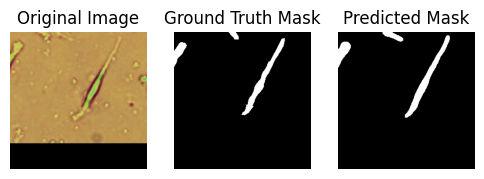

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


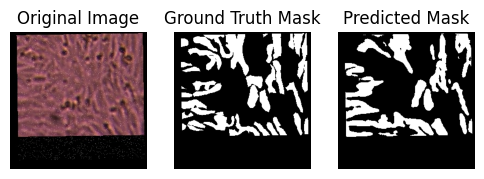

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


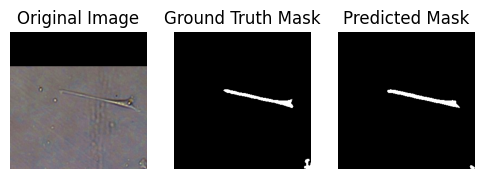

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


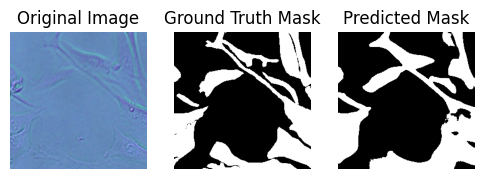

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


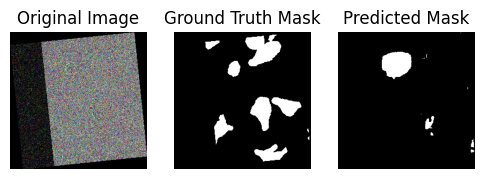

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


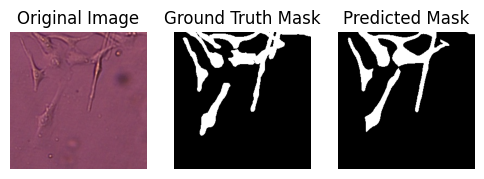

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


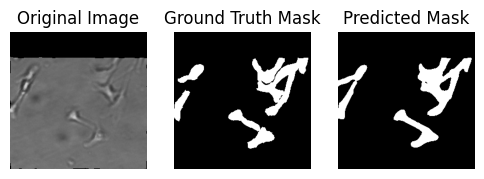

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_7.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


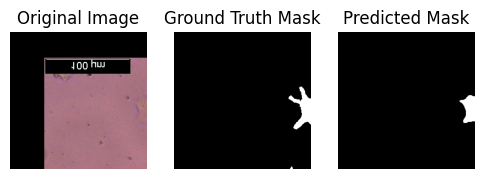

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_8.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


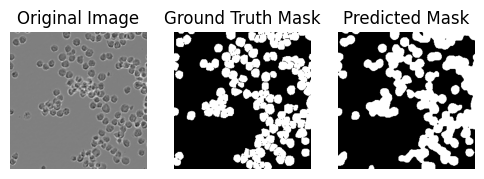

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_9.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


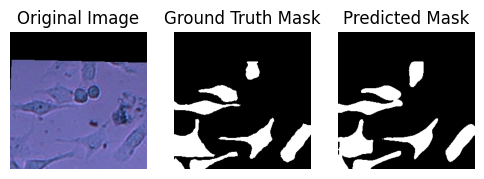

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


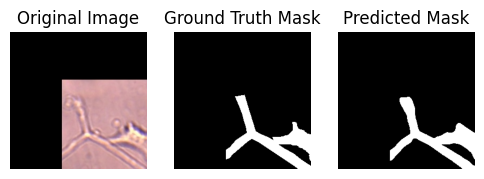

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_11.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


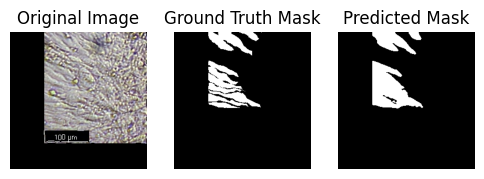

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_12.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


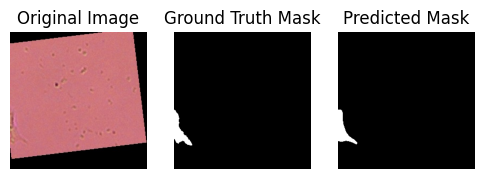

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


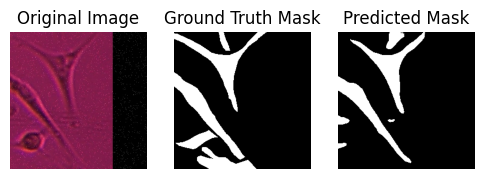

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_14.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


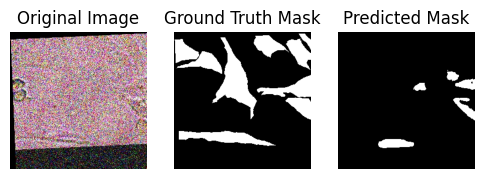

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_15.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


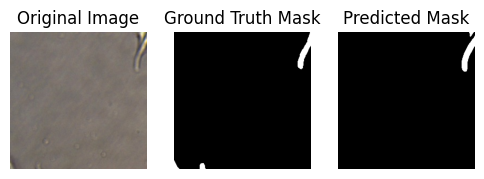

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_16.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


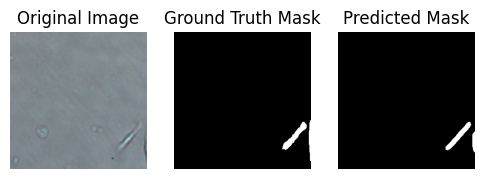

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_17.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


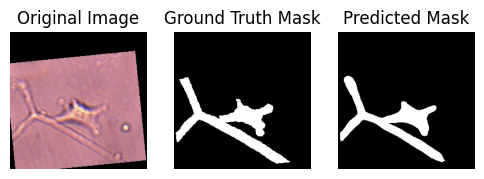

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_18.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


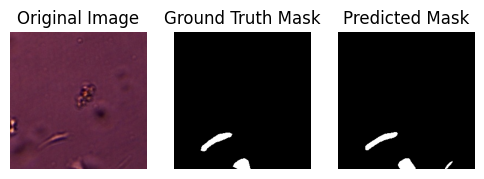

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_19.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


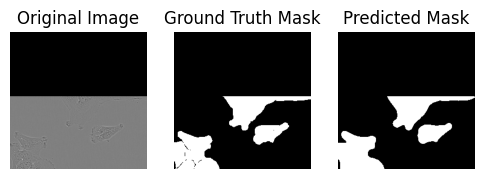

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_20.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


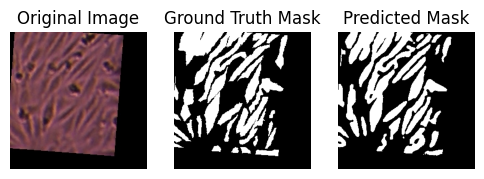

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_21.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


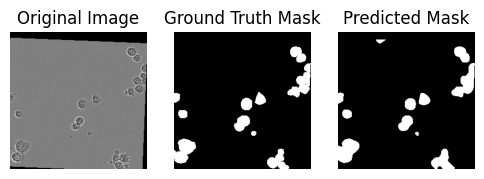

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_22.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


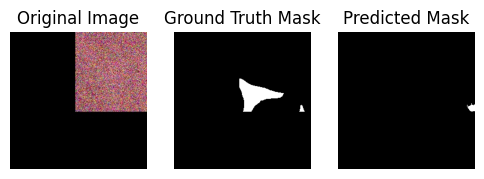

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_23.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


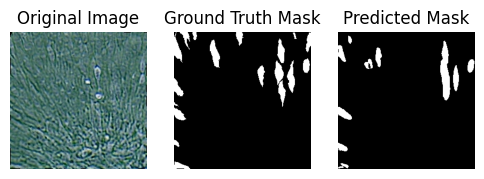

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_24.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


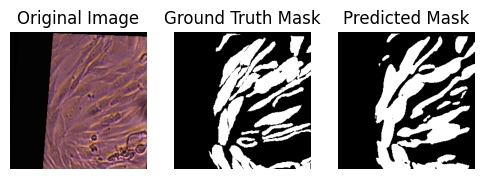

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_25.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


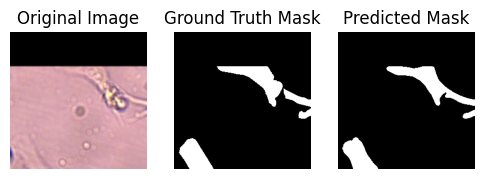

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_26.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


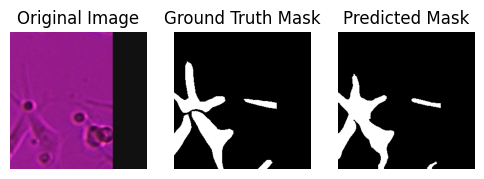

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_27.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


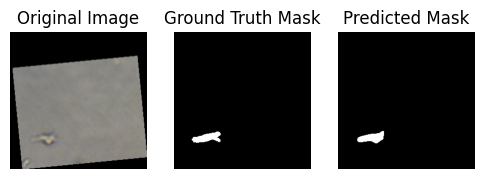

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_28.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


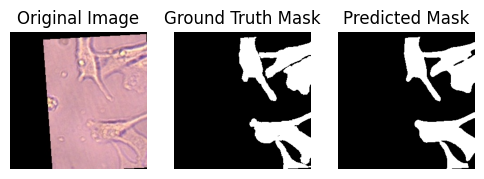

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_29.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


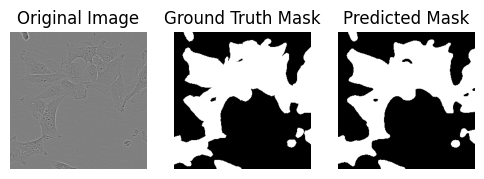

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_30.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


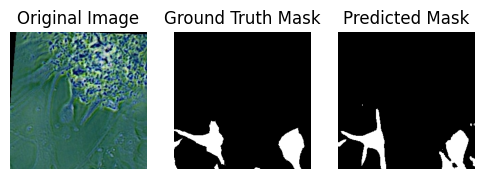

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_31.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


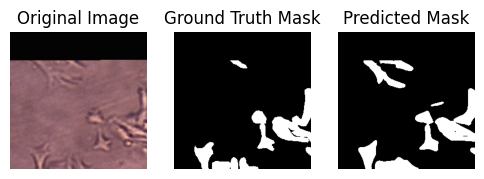

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_32.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


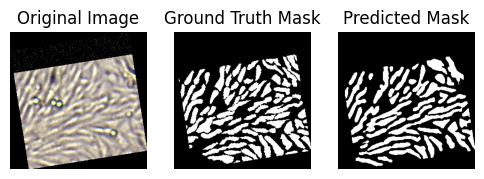

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_33.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


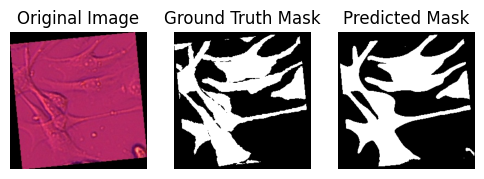

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_34.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


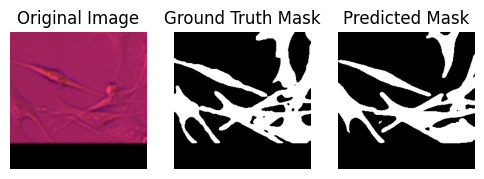

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_35.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


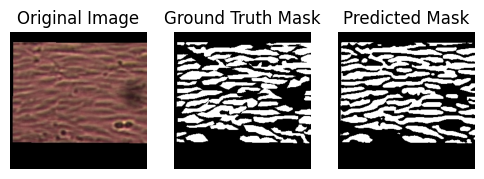

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_36.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


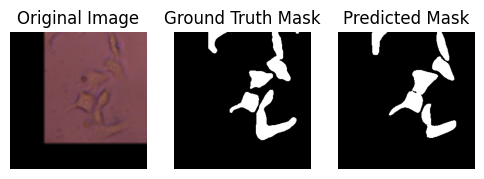

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_37.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


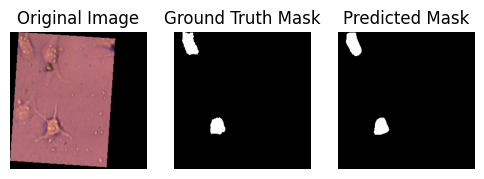

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_38.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


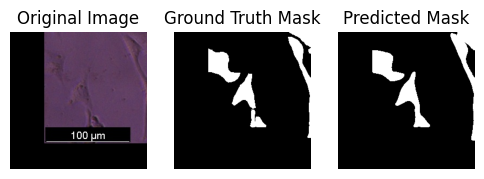

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_39.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


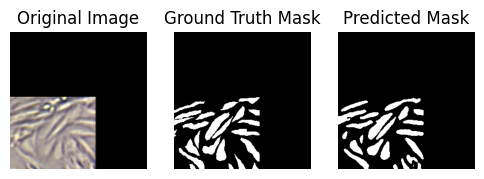

Saved: /kaggle/working/output/_attn_dice_2025-08-02 16:19:30/prediction_40.png


In [ ]:
def visualize_predictions(generator, model, num_images=5, save_dir=out_path):
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

    for i in range(num_images):
        X_batch, Y_batch = generator[i]
        preds = (model.predict(X_batch) > 0.5).astype("int32")

        fig, axs = plt.subplots(1, 3, figsize=(6, 2))

        axs[0].imshow(X_batch[0])
        axs[0].set_title("Original Image")

        axs[1].imshow(Y_batch[0].squeeze(), cmap='gray')
        axs[1].set_title("Ground Truth Mask")

        axs[2].imshow(preds[0].squeeze(), cmap='gray')
        axs[2].set_title("Predicted Mask")

        # Remove axes for clarity
        for ax in axs:
            ax.axis('off')

        # Save figure
        fig_path = os.path.join(save_dir, f"prediction_{i+1}.png")
        plt.savefig(fig_path, bbox_inches='tight')
        #plt.close(fig)

        # Display inline
        plt.show(fig)

        # Optional: close to free memory
        plt.close(fig)
        print(f"Saved: {fig_path}")

# Run Visualization
visualize_predictions(val_gen, model, num_images=40)

In [ ]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=22f586f8f234d2bd21bba1e2c9ca778b765be1da8f056ea51622af1cf2e7c771
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [ ]:
import platform
import psutil
import cpuinfo
import GPUtil
import subprocess
import pkg_resources
import socket
from datetime import datetime

def get_hardware_info():
    print("\n" + "="*40 + " Hardware Information " + "="*40)

    # System Information
    print("\n" + "-"*20 + " System Information " + "-"*20)
    print(f"System: {platform.system()}")
    print(f"Node Name: {platform.node()}")
    print(f"Release: {platform.release()}")
    print(f"Version: {platform.version()}")
    print(f"Machine: {platform.machine()}")
    print(f"Processor: {platform.processor()}")

    # CPU Information
    print("\n" + "-"*20 + " CPU Information " + "-"*20)
    cpu_info = cpuinfo.get_cpu_info()
    print(f"Processor: {cpu_info['brand_raw']}")
    print(f"Architecture: {cpu_info['arch']}")
    print(f"Bits: {cpu_info['bits']}")
    print(f"Count: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count(logical=True)} logical")
    print(f"Max Frequency: {psutil.cpu_freq().max:.2f} MHz")
    print(f"Current Frequency: {psutil.cpu_freq().current:.2f} MHz")

    # Memory Information
    print("\n" + "-"*20 + " Memory Information " + "-"*20)
    svmem = psutil.virtual_memory()
    print(f"Total RAM: {svmem.total / (1024**3):.2f} GB")
    print(f"Available RAM: {svmem.available / (1024**3):.2f} GB")
    print(f"Used RAM: {svmem.used / (1024**3):.2f} GB")
    print(f"RAM Usage: {svmem.percent}%")

    # Disk Information
    print("\n" + "-"*20 + " Disk Information " + "-"*20)
    partitions = psutil.disk_partitions()
    for partition in partitions:
        try:
            usage = psutil.disk_usage(partition.mountpoint)
            print(f"Device: {partition.device}")
            print(f"  Mountpoint: {partition.mountpoint}")
            print(f"  File System: {partition.fstype}")
            print(f"  Total Size: {usage.total / (1024**3):.2f} GB")
            print(f"  Used: {usage.used / (1024**3):.2f} GB")
            print(f"  Free: {usage.free / (1024**3):.2f} GB")
            print(f"  Usage: {usage.percent}%")
        except PermissionError:
            continue

    # GPU Information
    print("\n" + "-"*20 + " GPU Information " + "-"*20)
    try:
        gpus = GPUtil.getGPUs()
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu.name}")
            print(f"  Driver: {gpu.driver}")
            print(f"  Memory Total: {gpu.memoryTotal} MB")
            print(f"  Memory Free: {gpu.memoryFree} MB")
            print(f"  Memory Used: {gpu.memoryUsed} MB")
            print(f"  GPU Utilization: {gpu.load*100}%")
            print(f"  Temperature: {gpu.temperature} °C")
    except Exception as e:
        print(f"Could not retrieve GPU information: {e}")

def get_installed_libraries():
    print("\n" + "="*40 + " Library Information " + "="*40)

    # Get all installed packages
    installed_packages = pkg_resources.working_set

    # Common ML/DL libraries to check
    important_libraries = [
        'tensorflow', 'tensorflow-gpu', 'torch', 'torchvision', 'torchaudio',
        'numpy', 'scipy', 'pandas', 'matplotlib', 'scikit-learn',
        'keras', 'opencv-python', 'pillow', 'jupyter', 'seaborn',
        'xgboost', 'lightgbm', 'catboost', 'transformers', 'datasets',
        'flask', 'django', 'fastapi', 'requests', 'beautifulsoup4',
        'pytorch', 'cuda', 'cudnn'
    ]

    print("\n" + "-"*20 + " Key Libraries " + "-"*20)
    for lib in important_libraries:
        try:
            version = pkg_resources.get_distribution(lib).version
            print(f"{lib}: {version}")
        except:
            pass

    # Get all installed packages if needed
    # print("\n" + "-"*20 + " All Installed Packages " + "-"*20)
    # for package in sorted(installed_packages, key=lambda x: x.key):
    #     print(f"{package.key}: {package.version}")

def save_to_file(info, filename="system_info.txt"):
    with open(filename, "w") as f:
        f.write(info)
    print(f"\nInformation saved to {filename}")

def main():
    import io
    import sys

    # Redirect stdout to capture all output
    old_stdout = sys.stdout
    sys.stdout = buffer = io.StringIO()

    # Get current date and time
    print(f"System and Library Information - {sys_info}")
    print("="*100)

    # Get hardware info
    get_hardware_info()

    # Get library info
    get_installed_libraries()

    # Restore stdout
    sys.stdout = old_stdout

    # Get the captured output
    info = buffer.getvalue()

    # Print to console
    print(info)

    # Save to file
    save_to_file(info)

if __name__ == "__main__":
    main()

System and Library Information - 2025-08-02 16:19:30

======================================== Hardware Information ========================================

-------------------- System Information --------------------
System: Linux
Node Name: a33c9a7715e4
Release: 6.6.56+
Version: #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
Machine: x86_64
Processor: x86_64

-------------------- CPU Information --------------------
Processor: Intel(R) Xeon(R) CPU @ 2.00GHz
Architecture: X86_64
Bits: 64
Count: 2 physical, 4 logical
Max Frequency: 0.00 MHz
Current Frequency: 2000.15 MHz

-------------------- Memory Information --------------------
Total RAM: 31.35 GB
Available RAM: 25.86 GB
Used RAM: 4.98 GB
RAM Usage: 17.5%

-------------------- Disk Information --------------------
Device: /dev/loop1
  Mountpoint: /kaggle/input
  File System: ext4
  Total Size: 19.52 GB
  Used: 6.87 GB
  Free: 12.63 GB
  Usage: 35.2%
Device: /dev/loop1
  Mountpoint: /kaggle/working
  File System: ext4
  Total 

In [ ]:
import os
import shutil
import glob

# Base output directory
base_dir = "/kaggle/working/output/_attn_dice_2025-08-02 16:19:30"
images_dir = os.path.join(base_dir, "images")

# Create images directory if it doesn't exist
os.makedirs(images_dir, exist_ok=True)

# Move all prediction_*.png files into images/
for file_path in glob.glob(os.path.join(base_dir, "prediction_*.png")):
    shutil.move(file_path, images_dir)

print("✅ All prediction PNGs moved to 'images/' folder.")

✅ All prediction PNGs moved to 'images/' folder.


In [ ]:
import shutil
import os

base_dir = "/kaggle/working"
target_dir = os.path.join(base_dir, "output/_attn_dice_2025-08-02 16:19:30")

# Move system_info.txt
shutil.move(os.path.join(base_dir, "system_info.txt"), os.path.join(target_dir, "system_info.txt"))

# Move tensorboard directory
shutil.move(os.path.join(base_dir, "tensorboard"), os.path.join(target_dir, "tensorboard"))

print("✅ Moved tensorboard and system_info.txt to the output directory.")


✅ Moved tensorboard and system_info.txt to the output directory.


In [ ]:
import os

root_dir = '/kaggle/working'

for root, dirs, files in os.walk(root_dir):
    level = root.replace(root_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

working/
    .virtual_documents/
    output/
        _attn_dice_2025-08-02 16:19:30/
            system_info.txt
            training_log.csv
            tensorboard/
                log/
                    fit_20250802-162020/
                        train/
                            events.out.tfevents.1754151626.a33c9a7715e4.36.0.v2
                        validation/
                            events.out.tfevents.1754152156.a33c9a7715e4.36.1.v2
            keras/
                _attn_dice_2025-08-02 16:19:30_1st_11.keras
                _attn_dice_2025-08-02 16:19:30_1st_22.keras
                _attn_dice_2025-08-02 16:19:30_1st_18.keras
                _attn_dice_2025-08-02 16:19:30_1st_12.keras
                _attn_dice_2025-08-02 16:19:30_1st_10.keras
                _attn_dice_2025-08-02 16:19:30_1st_03.keras
                _attn_dice_2025-08-02 16:19:30_1st_02.keras
                _attn_dice_2025-08-02 16:19:30_1st_21.keras
                _attn_dice_2025-08-02 16:19:3

In [ ]:
import zipfile
import os
from tqdm import tqdm

folder_to_zip = "/kaggle/working/output/_attn_dice_2025-08-02 16:19:30"
zip_file_path = "/kaggle/working/008VggDICE_ADV_Atten_IA_8m_increased.zip"

# Gather all file paths
file_list = []
for root, _, files in os.walk(folder_to_zip):
    for file in files:
        file_list.append(os.path.join(root, file))

# Zip with progress bar
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_path in tqdm(file_list, desc="Zipping files"):
        arcname = os.path.relpath(file_path, folder_to_zip)
        zipf.write(file_path, arcname=arcname)

print("✅ Zipping complete.")

Zipping files: 100%|██████████| 66/66 [06:22<00:00,  5.80s/it]

✅ Zipping complete.
